In [22]:
import pandas as pd
import os
from os import listdir
from pandas import read_csv
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import scipy.stats as s
from sklearn.metrics import r2_score
import math

warnings.filterwarnings("ignore")

work_dir = '/Users/xiaodanxu/Documents/SynthFirm.nosync'
os.chdir(work_dir)
meter_to_mile = 0.00062137
min_to_hour = 1/60
sec_to_hour = 1/3600

In [2]:
# load BEAM skim 
region = 'SFBay_sample'
skim_dir = 'RawData/BEAM_skims/' + region
skim_files = listdir(skim_dir)

beam_skim_out = None
var_to_keep = ['timePeriod', 'pathType',
               'origin', 'destination', 
               'TIME_minutes', 'DIST_meters']

var_to_keep_aus = ['hour', 'mode', 
                   'origTaz', 'destTaz', 
                   'travelTimeInS',
                   'distanceInM', 'observations']
for file in skim_files:
    print(file)
    if file == '.DS_Store':
        continue
    beam_skim = read_csv(os.path.join(skim_dir, file))
    print(len(beam_skim))
    if region == 'SFBay':
        beam_skim = beam_skim.loc[beam_skim['pathType'] == 'SOV']
        beam_skim = beam_skim.loc[beam_skim['timePeriod'] == 'AM']
        beam_skim = beam_skim[var_to_keep]
    elif region == 'Austin' or region == 'SFBay_sample':
        beam_skim = beam_skim.loc[beam_skim['mode'] == 'CAR']
#         beam_skim = beam_skim.loc[beam_skim['hour'] == 7]
        beam_skim = beam_skim[var_to_keep_aus]
    print(len(beam_skim))
    beam_skim_out = pd.concat([beam_skim_out, beam_skim])
#     break
# print(beam_skim.columns)
beam_skim_out.head(5)

0.skimsOD.csv.gz
1717199
844618


,hour,mode,origTaz,destTaz,travelTimeInS,distanceInM,observations
1,15,CAR,948,874,298.0,6877.0140,1
8,17,CAR,1136,1246,1411.0,30009.4550,1
10,17,CAR,1068,1072,253.5,4846.1565,2
11,17,CAR,604,668,739.0,16641.7630,1
12,19,CAR,71,104,452.0,6896.0900,1


In [3]:
beam_skim_out.observations.sum()

1287932

In [4]:
cbg_to_taz_file = 'cbg_taz_mapping.csv'
cbg_to_taz = read_csv('RawData/BEAM_skims/' + cbg_to_taz_file)

cbg_to_taz['taz1454'] = cbg_to_taz['taz1454'].astype(int)
cbg_to_taz.head(5)

,GEOID,taz1454
0,60411242004,1446
1,60750108001,35
2,60014227001,1007
3,60750611002,25
4,60855094013,365


In [5]:
beam_skim_sample = beam_skim.head(1000)
beam_skim_sample.to_csv('RawData/beam_skim_sample_sf.csv')
# print(beam_skim.pathType.unique())
# print(beam_skim.timePeriod.unique())

In [20]:
def weighted_avg_and_std(df, values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(df[values], weights=df[weights])
    # Fast and numerically precise:
    variance = np.average((df[values]-average)**2, weights=df[weights])
    return (average, math.sqrt(variance))

In [23]:
if region == 'SFBay':
    beam_skim_out.loc[:, 'beam_dist_mile'] = beam_skim_out.loc[:, 'DIST_meters'] * meter_to_mile
    beam_skim_out.loc[:, 'beam_time_hour'] = beam_skim_out.loc[:, 'TIME_minutes'] * min_to_hour
elif region == 'Austin' or region == 'SFBay_sample':
    beam_skim_out = beam_skim_out.loc[beam_skim_out['travelTimeInS'] > 0]
    beam_skim_out.loc[:, 'beam_dist_mile'] = beam_skim_out.loc[:, 'distanceInM'] * meter_to_mile
    beam_skim_out.loc[:, 'beam_time_hour'] = beam_skim_out.loc[:, 'travelTimeInS'] * sec_to_hour
    beam_skim_out.loc[:, 'beam_speed_mph'] = beam_skim_out.loc[:, 'beam_dist_mile'] / \
    beam_skim_out.loc[:, 'beam_time_hour']
    print(len(beam_skim_out))

print(beam_skim_out['beam_time_hour'].mean())
print(beam_skim_out['beam_dist_mile'].mean())

beam_skim_out = beam_skim_out.dropna()
print(weighted_avg_and_std(beam_skim_out, 'beam_speed_mph','observations'))
beam_skim_out.head(5)

844525
0.19790471701003917
9.602482610225932
(45.136751464966956, 9.240800888229582)


,hour,mode,origTaz,destTaz,travelTimeInS,distanceInM,observations,beam_dist_mile,beam_time_hour,beam_speed_mph
1,15,CAR,948,874,298.0,6877.0140,1,4.273170,0.082778,51.622190
8,17,CAR,1136,1246,1411.0,30009.4550,1,18.646975,0.391944,47.575556
10,17,CAR,1068,1072,253.5,4846.1565,2,3.011256,0.070417,42.763403
11,17,CAR,604,668,739.0,16641.7630,1,10.340692,0.205278,50.374144
12,19,CAR,71,104,452.0,6896.0900,1,4.285023,0.125556,34.128505


In [17]:
beam_skim_out.travelTimeInS.min()

0.0

In [19]:
# load INRIX skim data
inrix_dir = 'PrivateData/INRIX'
inrix_file = 'CA_travel_time.csv'
inrix_skim = read_csv(os.path.join(inrix_dir, inrix_file))
inrix_skim = inrix_skim.loc[inrix_skim['vehicle_weight_class'] == 1]
inrix_skim.head(5)

,start_cbg,end_cbg,start_hour,vehicle_weight_class,trip_distance_mile,travel_time_h,trip_count,trip_avg_speed_mph
0,60014001001,60014001001,4,1,10.548005,0.373056,3,28.274623
1,60014001001,60014001001,5,1,9.840179,0.415040,7,23.709008
2,60014001001,60014001001,6,1,0.993910,0.164778,5,6.031818
3,60014001001,60014001001,7,1,4.618263,0.299974,53,15.395556
5,60014001001,60014001001,8,1,3.939518,0.298660,74,13.190650


<Axes: xlabel='start_hour'>

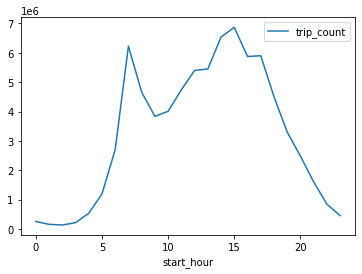

In [16]:
hourly_trip_count = inrix_skim.groupby('start_hour')[['trip_count']].sum()
hourly_trip_count.plot()

In [24]:
if region == 'SFBay_sample':
    cbg_to_taz.columns = ['start_cbg', 'origTaz']
    inrix_skim = pd.merge(inrix_skim, cbg_to_taz,
                         on = 'start_cbg', how = 'left')
    cbg_to_taz.columns = ['end_cbg', 'destTaz']
    inrix_skim = pd.merge(inrix_skim, cbg_to_taz,
                         on = 'end_cbg', how = 'left')
    inrix_skim.loc[:, 'inrix_dist_mile'] = \
    inrix_skim.loc[:, 'trip_distance_mile'] * \
    inrix_skim.loc[:, 'trip_count'] 
    inrix_skim.loc[:, 'inrix_time_hour'] = \
    inrix_skim.loc[:, 'travel_time_h'] * \
    inrix_skim.loc[:, 'trip_count'] 
    inrix_skim_by_taz = \
    inrix_skim.groupby(['origTaz','destTaz', 'start_hour'])[['inrix_dist_mile', 'inrix_time_hour', 'trip_count']].sum()
    inrix_skim_by_taz = inrix_skim_by_taz.reset_index()
    inrix_skim_by_taz.loc[:, 'inrix_dist_mile'] = \
    inrix_skim_by_taz.loc[:, 'inrix_dist_mile'] / \
    inrix_skim_by_taz.loc[:, 'trip_count'] 
    inrix_skim_by_taz.loc[:, 'inrix_time_hour'] = \
    inrix_skim_by_taz.loc[:, 'inrix_time_hour'] / \
    inrix_skim_by_taz.loc[:, 'trip_count'] 
inrix_skim_by_taz.head(5)

,origTaz,destTaz,start_hour,inrix_dist_mile,inrix_time_hour,trip_count
0,2.0,2.0,0,11.814841,1.185556,4
1,2.0,2.0,1,3.451250,0.343056,1
2,2.0,2.0,2,3.902351,0.289653,4
3,2.0,2.0,3,6.885306,0.731250,2
4,2.0,2.0,4,2.356582,0.296833,5


In [46]:
# apply this to new SF results
if region == 'SFBay_sample':
    inrix_skim_by_taz.loc[:, 'inrix_speed_mph'] = \
    inrix_skim_by_taz.loc[:, 'inrix_dist_mile'] / \
    inrix_skim_by_taz.loc[:, 'inrix_time_hour']
    beam_skim_out = beam_skim_out.rename(columns = {'origTaz':'origin',
                                          'destTaz': 'destination'})
    inrix_skim_by_taz = inrix_skim_by_taz.rename(columns = {'origTaz':'origin',
                                              'destTaz': 'destination',
                                             'trip_count': 'sample_size',
                                            'start_hour': 'hour'})
    beam_skim_compare = pd.merge(beam_skim_out,
                                 inrix_skim_by_taz,
                                 on = ['origin', 'destination', 'hour'],
                                 how = 'inner')
print(len(beam_skim_compare))
print(beam_skim_compare['sample_size'].sum())
print(beam_skim_compare['observations'].sum())
beam_skim_compare.head(5)

426508
5295101
806876


,hour,mode,origin,destination,travelTimeInS,distanceInM,observations,beam_dist_mile,beam_time_hour,beam_speed_mph,inrix_dist_mile,inrix_time_hour,sample_size,inrix_speed_mph
0,15,CAR,948,874,298.0,6877.0140,1,4.273170,0.082778,51.622190,6.415079,0.494722,2,12.967031
1,17,CAR,1136,1246,1411.0,30009.4550,1,18.646975,0.391944,47.575556,18.996870,0.453333,1,41.904860
2,17,CAR,1068,1072,253.5,4846.1565,2,3.011256,0.070417,42.763403,2.419654,0.185662,13,13.032546
3,19,CAR,71,104,452.0,6896.0900,1,4.285023,0.125556,34.128505,1.883509,0.299444,1,6.290013
4,14,CAR,427,674,900.0,24547.2520,1,15.252926,0.250000,61.011704,16.307931,0.566556,5,28.784347


In [29]:
# produce summary statistics
dist_r2 = r2_score(beam_skim_compare['inrix_dist_mile'], 
                  beam_skim_compare['beam_dist_mile'])
print('r2 score for routed distance ' + str(np.round(dist_r2, 2)))

time_r2 = r2_score(beam_skim_compare['inrix_time_hour'], 
                  beam_skim_compare['beam_time_hour'])
print('r2 score for routed travel time ' + str(np.round(time_r2, 2)))

print(weighted_avg_and_std(beam_skim_compare, 'inrix_dist_mile','sample_size'))
print(weighted_avg_and_std(beam_skim_compare, 'beam_dist_mile','observations'))

print(weighted_avg_and_std(beam_skim_compare, 'inrix_time_hour','sample_size'))
print(weighted_avg_and_std(beam_skim_compare, 'beam_time_hour','observations'))

print(weighted_avg_and_std(beam_skim_compare, 'inrix_speed_mph','sample_size'))
print(weighted_avg_and_std(beam_skim_compare, 'beam_speed_mph','observations'))
#       np.round(beam_skim_compare['beam_dist_mile'].mean(), 2),
#      np.round(beam_skim_compare['inrix_time_hour'].mean(), 2),
#      np.round(beam_skim_compare['beam_time_hour'].mean(), 2))

# print(np.round(beam_skim_compare['inrix_dist_mile'].std(), 2),
#       np.round(beam_skim_compare['beam_dist_mile'].std(), 2),
#      np.round(beam_skim_compare['inrix_time_hour'].std(), 2),
#      np.round(beam_skim_compare['beam_time_hour'].std(), 2))

r2 score for routed distance 0.62
r2 score for routed travel time -0.42
(3.77702897073142, 3.3825666360615303)
(4.665889363382093, 4.658025029956564)
(0.22529556859360292, 0.11975434097316404)
(0.10372889046423771, 0.09328514767452196)
(15.578451051923007, 5.895157443211996)
(43.370823527740406, 8.961796933579354)


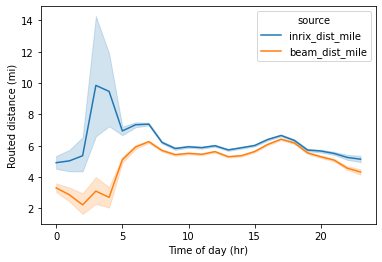

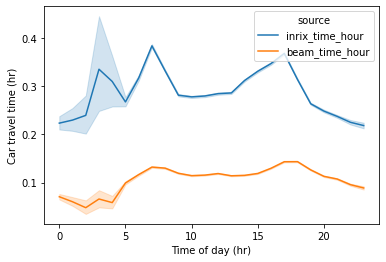

In [26]:
# validation by TOD
travel_dist_compare = pd.melt(beam_skim_compare, 
                              id_vars=['origin', 'destination', 'hour'], 
                              value_vars=['inrix_dist_mile', 'beam_dist_mile'],
                             var_name='source', value_name='distance')
# travel_dist_compare.head(5)
# sns.lineplot(data = travel_dist_compare, 
#              x="hour", y="distance", hue="source")
# plt.show()

travel_time_compare = pd.melt(beam_skim_compare, 
                              id_vars=['origin', 'destination', 'hour'], 
                              value_vars=['inrix_time_hour', 'beam_time_hour'],
                             var_name='source', value_name='time')
# travel_dist_compare.head(5)
# dist plot
sns.lineplot(data = travel_dist_compare, 
             x="hour", y="distance", hue="source")
plt.xlabel('Time of day (hr)')
plt.ylabel('Routed distance (mi)')
plt.savefig('plots_SF/SF_skim_dist_by_TOD.png', dpi = 300)
plt.show()

# time plot
sns.lineplot(data = travel_time_compare, 
             x="hour", y="time", hue="source")
plt.xlabel('Time of day (hr)')
plt.ylabel('Car travel time (hr)')
plt.savefig('plots_SF/SF_skim_time_by_TOD.png', dpi = 300)
plt.show()

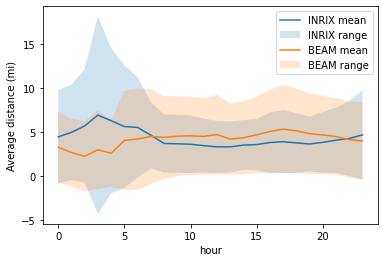

In [62]:
# plot weighted distance
hour_dist_inrix = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'inrix_dist_mile', 'sample_size')))

hour_dist_inrix.columns = ['avg distance', 'std error']
hour_dist_inrix = hour_dist_inrix.reset_index()
hour_dist_inrix.loc[:, 'source'] = 'INRIX'
hour_dist_inrix.loc[:, 'upper'] = hour_dist_inrix.loc[:, 'avg distance'] + \
hour_dist_inrix.loc[:, 'std error']
hour_dist_inrix.loc[:, 'lower'] = hour_dist_inrix.loc[:, 'avg distance'] - \
hour_dist_inrix.loc[:, 'std error']
hour_dist_inrix.head(5)

hour_dist_beam = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'beam_dist_mile', 'observations')))

hour_dist_beam.columns = ['avg distance', 'std error']
hour_dist_beam = hour_dist_beam.reset_index()
hour_dist_beam.loc[:, 'source'] = 'BEAM'
hour_dist_beam.loc[:, 'upper'] = hour_dist_beam.loc[:, 'avg distance'] + \
hour_dist_beam.loc[:, 'std error']
hour_dist_beam.loc[:, 'lower'] = hour_dist_beam.loc[:, 'avg distance'] - \
hour_dist_beam.loc[:, 'std error']
hour_dist_beam.head(5)

# generate plot

ax = sns.lineplot(data = hour_dist_inrix, x = 'hour', y="avg distance", ci=None)
ax.fill_between(hour_dist_inrix.hour, hour_dist_inrix.lower, hour_dist_inrix.upper, alpha=0.2)

sns.lineplot(data = hour_dist_beam, x = 'hour', y="avg distance", ci=None, ax = ax)
ax.fill_between(hour_dist_beam.hour, hour_dist_beam.lower, hour_dist_beam.upper, alpha=0.2)

plt.legend(['INRIX mean', 'INRIX range', 'BEAM mean', 'BEAM range'])
plt.ylabel('Average distance (mi)')
plt.savefig('plots_SF/SF_skim_dist_by_TOD_weighted.png', dpi = 300)
plt.show()

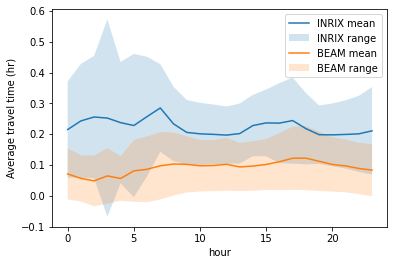

In [63]:
# plot weighted time
hour_time_inrix = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'inrix_time_hour', 'sample_size')))

hour_time_inrix.columns = ['avg travel time', 'std error']
hour_time_inrix = hour_time_inrix.reset_index()
hour_time_inrix.loc[:, 'source'] = 'INRIX'
hour_time_inrix.loc[:, 'upper'] = hour_time_inrix.loc[:, 'avg travel time'] + \
hour_time_inrix.loc[:, 'std error']
hour_time_inrix.loc[:, 'lower'] = hour_time_inrix.loc[:, 'avg travel time'] - \
hour_time_inrix.loc[:, 'std error']
hour_time_inrix.head(5)

hour_time_beam = \
beam_skim_compare.groupby(['hour']).apply(lambda x: pd.Series(weighted_avg_and_std(x, 'beam_time_hour', 'observations')))

hour_time_beam.columns = ['avg travel time', 'std error']
hour_time_beam = hour_time_beam.reset_index()
hour_time_beam.loc[:, 'source'] = 'BEAM'
hour_time_beam.loc[:, 'upper'] = hour_time_beam.loc[:, 'avg travel time'] + \
hour_time_beam.loc[:, 'std error']
hour_time_beam.loc[:, 'lower'] = hour_time_beam.loc[:, 'avg travel time'] - \
hour_time_beam.loc[:, 'std error']
hour_time_beam.head(5)

# generate plot

ax = sns.lineplot(data = hour_time_inrix, x = 'hour', y="avg travel time", ci=None)
ax.fill_between(hour_time_inrix.hour, hour_time_inrix.lower, hour_time_inrix.upper, alpha=0.2)

sns.lineplot(data = hour_time_beam, x = 'hour', y="avg travel time", ci=None, ax = ax)
ax.fill_between(hour_time_beam.hour, hour_time_beam.lower, hour_time_beam.upper, alpha=0.2)

plt.legend(['INRIX mean', 'INRIX range', 'BEAM mean', 'BEAM range'])
plt.ylabel('Average travel time (hr)')
plt.savefig('plots_SF/SF_skim_time_by_TOD_weighted.png', dpi = 300)
plt.show()

In [56]:
beam_skim_compare.groupby(['hour']).apply(lambda x: weighted_avg_and_std(x, 'inrix_dist_mile', 'sample_size'))

hour
0       (4.457445918626792, 5.302225057181969)
1       (4.970044932710635, 5.428951929850439)
2      (5.7068375503697695, 6.452051997827735)
3      (6.942096094858466, 11.237229677330925)
4       (6.309460957680331, 8.268268305543046)
5      (5.637467803076038, 6.9744498002002855)
6      (5.536406097564707, 5.7256716555121105)
7        (4.65699275619298, 3.769729057768812)
8      (3.715416676930803, 3.2977468430246404)
9       (3.67837048701256, 3.2998343124075458)
10       (3.625754518582102, 3.27242281069907)
11     (3.466769819672153, 3.0668931719342507)
12     (3.3289841595117333, 2.951329705327543)
13     (3.326347531076025, 2.8981290208297557)
14      (3.5318237559511694, 2.83224475212182)
15     (3.5883305061893975, 2.918341094361562)
16      (3.820463139064155, 3.417719580049251)
17    (3.9185601992988466, 3.5880340335902643)
18     (3.779673731541137, 3.3860944497299283)
19    (3.6518016562399516, 3.1197944610463297)
20     (3.8454384889593394, 3.444795773565022)
21      

In [33]:
# inrix_skim_am = inrix_skim.loc[inrix_skim['start_hour'] == 7]
# inrix_skim_am = inrix_skim_am[['start_cbg', 'end_cbg', 
#                                'trip_distance_mile', 'travel_time_h', 'trip_count']]
# inrix_skim_am.columns = ['origin', 'destination', 
#                          'inrix_dist_mile', 'inrix_time_hour', 'sample_size']
# if region == 'Austin':
#     beam_skim_out = beam_skim_out.rename(columns = {'origTaz':'origin',
#                                           'destTaz': 'destination'})
# beam_skim_compare = pd.merge(beam_skim_out,
#                              inrix_skim_am,
#                              on = ['origin', 'destination'],
#                              how = 'inner')
# print(len(beam_skim_compare))
# beam_skim_compare.head(5)

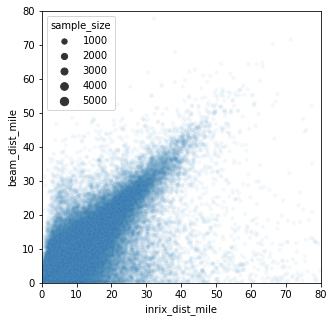

In [32]:

plt.figure(figsize = (5,5))
sns.scatterplot(data=beam_skim_compare, x="inrix_dist_mile", 
                y="beam_dist_mile", alpha = 0.05, 
                size = 'sample_size')
plt.xlim([0,80])
plt.ylim([0,80])
plt.show()

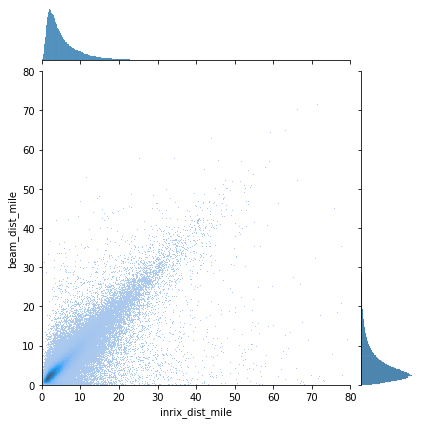

In [28]:
sns.jointplot(data=beam_skim_compare, x="inrix_dist_mile", 
                y="beam_dist_mile", kind="hist")
plt.xlim([0,80])
plt.ylim([0,80])
plt.savefig('plots_SF/SF_travel_dist_skim_validation.png', dpi = 300, 
           bbox_inches = 'tight')
plt.show()

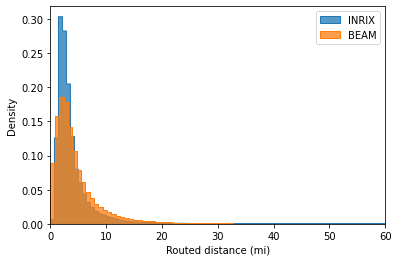

In [45]:
sns.histplot(data=beam_skim_compare, x="inrix_dist_mile", 
             weights = 'sample_size', bins = 300, stat = 'density', 
             element = 'step', kde=False)

sns.histplot(data=beam_skim_compare, x="beam_dist_mile", 
             weights = 'observations', bins = 100, stat = 'density', 
             element = 'step', kde=False)

plt.xlim([0, 60])
plt.xlabel('Routed distance (mi)')
plt.legend(['INRIX', 'BEAM'])
plt.savefig('plots_SF/SF_travel_dist_skim_weighted.png', dpi = 300, 
           bbox_inches = 'tight')

plt.show()

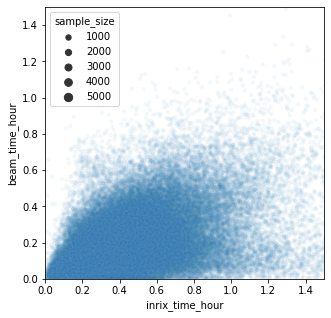

In [31]:
plt.figure(figsize = (5,5))
sns.scatterplot(data=beam_skim_compare, x="inrix_time_hour", 
                y="beam_time_hour", alpha = 0.05, 
                size = 'sample_size')
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.show()

In [30]:
print(len(beam_skim_compare.origin.unique()))
print(len(beam_skim_compare.destination.unique()))

1385
1387


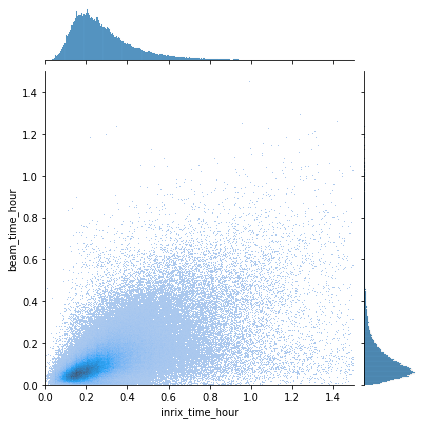

In [29]:
sns.jointplot(data=beam_skim_compare, x="inrix_time_hour", 
                y="beam_time_hour", kind="hist")
plt.xlim([0,1.5])
plt.ylim([0,1.5])
plt.savefig('plots_SF/SF_travel_time_skim_validation.png', dpi = 300, 
           bbox_inches = 'tight')
plt.show()

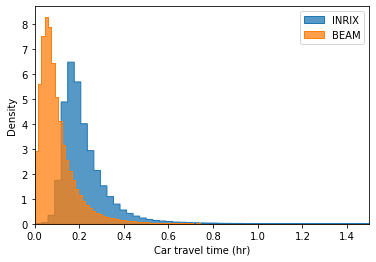

In [43]:
sns.histplot(data=beam_skim_compare, x="inrix_time_hour", 
             weights = 'sample_size', bins = 300, stat = 'density', 
             element = 'step', kde=False)

sns.histplot(data=beam_skim_compare, x="beam_time_hour", 
             weights = 'observations', bins = 100, stat = 'density', 
             element = 'step', kde=False)

plt.xlim([0, 1.5])
plt.xlabel('Car travel time (hr)')
plt.legend(['INRIX', 'BEAM'])
plt.savefig('plots_SF/SF_travel_time_skim_weighted.png', dpi = 300, 
           bbox_inches = 'tight')

plt.show()

In [21]:
# beam_skim_out.to_csv('RawData/travel_skim_beam.csv.zip')